# **Prophet model: Approach 2**

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from aggregate import *
from utils import *

In [142]:
# Read preprocessed data
data_raw = pd.read_csv('final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [143]:

# Split data according to category
data = split(data_raw)

Let's take a look at the unique dates to have an idea of the size of our time series.

In [144]:
for key in data.keys():
    print(f'Column: {key}'.ljust(19, ' ') + '--->' + f'Size = {data[key].date_etablissement_dpe.unique().shape[0]}'.rjust(12, ' '))

Column: admin      ---> Size = 4252
Column: centre_com ---> Size = 3418
Column: occup_cont ---> Size = 3246
Column: autre      ---> Size = 4043


**Aggregating columns with respect to the date column**

In [145]:
ts ={key: {freq: extract_vect_ts(df, freq) for freq in ['D', 'W', 'M']} for key, df in data.items()}

c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.resample(freq).mean().resample(freq).interpolate(method='linear')
c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.resample(freq).mean().resample(freq).interpolate(method='linear')
c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.resample(freq).mean().resample(freq).interpolate(method='linear')
c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be remove

In [146]:
ts['admin']['W']  # ts['sector']['frequency']

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2013-01-13,1974.000000,100.000000,661276.385727,6.863710e+06,27.130000
2013-01-20,1974.000000,100.000000,642131.351753,6.841609e+06,27.515000
2013-01-27,1974.000000,100.000000,622986.317779,6.819508e+06,27.900000
2013-02-03,1974.000000,100.000000,603841.283805,6.797406e+06,28.285000
2013-02-10,1974.000000,100.000000,584696.249830,6.775305e+06,28.670000
...,...,...,...,...,...
2024-12-08,1966.110170,234.024132,675958.215238,6.663887e+06,11.360938
2024-12-15,1966.023341,177.840398,661427.597506,6.661860e+06,8.770826
2024-12-22,1965.049847,173.369254,651383.875067,6.653682e+06,9.580173


_Remark:_ For the resampling step, only 156 rows out of our 4375 rows were interpolated, the remaining rows were already present in the dataset.

**Prediction and validation**

Before predicting let's define a function that splits our data into a train time series and test time series (it can be found in `aggregate.py`).

Now let's apply our model to predict ts_admin values. First let's do a train test split for every time series.

In [147]:
for sect in ts:
    for freq in ts[sect]:
        train, test = ttsplit(ts[sect][freq],test_size=0.15)
        ts[sect][freq] = {'train': train, 'test': test}

In [148]:
ts['admin']['W']['train'].tail()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2023-02-19,1961.930918,310.578354,679762.800618,6.704718e+06,11.991879
2023-02-26,1966.448198,258.482166,672940.993864,6.647513e+06,13.280765
2023-03-05,1964.896711,238.914673,639655.996045,6.650743e+06,12.349130
2023-03-12,1967.450409,299.359822,646461.545600,6.659405e+06,13.285918
2023-03-19,1968.310557,409.674144,635086.366758,6.702488e+06,11.655385


In [149]:
ts['admin']['W']['test'].head()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2023-03-26,1963.841848,226.918542,651089.831946,6.660787e+06,12.754762
2023-04-02,1964.295256,493.461595,671562.916629,6.636986e+06,9.278225
2023-04-09,1962.793442,277.382946,649888.803450,6.639849e+06,12.339568
2023-04-16,1965.087091,253.295260,664870.405874,6.654797e+06,11.778456
2023-04-23,1960.572276,257.582624,654913.671467,6.681319e+06,11.220162


In [150]:
## Prophet nomenclature
def Prophetnom(df):
    df.reset_index(inplace=True)
    df.rename(columns={'date_etablissement_dpe':'ds','emission_ges':'y'}, inplace=True)

Prophetnom(ts['admin']['W']['train'])
Prophetnom(ts['centre_com']['W']['train'])
Prophetnom(ts['autre']['W']['train'])
Prophetnom(ts['occup_cont']['W']['train'])

Prophetnom(ts['admin']['W']['test'])
Prophetnom(ts['centre_com']['W']['test'])
Prophetnom(ts['autre']['W']['test'])
Prophetnom(ts['occup_cont']['W']['test'])


In [151]:
ts_admin_W_all=pd.concat([ts['admin']['W']['train'],ts['admin']['W']['test']]).reset_index(drop=True)
ts_centre_com_W_all=pd.concat([ts['centre_com']['W']['train'],ts['centre_com']['W']['test']]).reset_index(drop=True)
ts_autre_W_all=pd.concat([ts['autre']['W']['train'],ts['autre']['W']['test']]).reset_index(drop=True)
ts_occup_cont_W_all=pd.concat([ts['occup_cont']['W']['train'],ts['occup_cont']['W']['test']]).reset_index(drop=True)

ts_admin_W_all.head()

,ds,annee_construction,surface_utile,coord_x,coord_y,y
0,2013-01-13,1974.0,100.0,661276.385727,6.863710e+06,27.130
1,2013-01-20,1974.0,100.0,642131.351753,6.841609e+06,27.515
2,2013-01-27,1974.0,100.0,622986.317779,6.819508e+06,27.900
3,2013-02-03,1974.0,100.0,603841.283805,6.797406e+06,28.285
4,2013-02-10,1974.0,100.0,584696.249830,6.775305e+06,28.670


In [152]:
model_admin=Prophet()
model_centre_com=Prophet()
model_autre=Prophet()
model_occup_cont=Prophet()


model_admin.add_regressor('annee_construction')
model_admin.add_regressor('surface_utile')
model_admin.add_regressor('coord_x')
model_admin.add_regressor('coord_y')

model_centre_com.add_regressor('annee_construction')
model_centre_com.add_regressor('surface_utile')
model_centre_com.add_regressor('coord_x')
model_centre_com.add_regressor('coord_y')

model_autre.add_regressor('annee_construction')
model_autre.add_regressor('surface_utile')
model_autre.add_regressor('coord_x')
model_autre.add_regressor('coord_y')

model_occup_cont.add_regressor('annee_construction')
model_occup_cont.add_regressor('surface_utile')
model_occup_cont.add_regressor('coord_x')
model_occup_cont.add_regressor('coord_y')

model_admin.fit(ts['admin']['W']['train'])
model_centre_com.fit(ts['centre_com']['W']['train'])
model_autre.fit(ts['autre']['W']['train'])
model_occup_cont.fit(ts['occup_cont']['W']['train'])

# future_admin = model_admin.make_future_dataframe(periods=ts['admin']['W']['test'].shape[0], freq='W')
# future_centre_com = model_centre_com.make_future_dataframe(periods=ts['centre_com']['W']['test'].shape[0], freq='W')
# future_autre = model_autre.make_future_dataframe(periods=ts['autre']['W']['test'].shape[0], freq='W')
# future_occup_cont = model_occup_cont.make_future_dataframe(periods=ts['occup_cont']['W']['test'].shape[0], freq='W')

# future_admin['annee_construction']=ts['admin']['W']['test']['annee_construction']
# future_admin['surface_utile']=ts['admin']['W']['test']['surface_utile']
# future_admin['coord_x']=ts['admin']['W']['test']['coord_x']
# future_admin['coord_y']=ts['admin']['W']['test']['coord_y']

# future_centre_com['annee_construction']=ts['centre_com']['W']['test']['annee_construction']
# future_centre_com['surface_utile']=ts['centre_com']['W']['test']['surface_utile']
# future_centre_com['coord_x']=ts['centre_com']['W']['test']['coord_x']
# future_centre_com['coord_y']=ts['centre_com']['W']['test']['coord_y']

# future_autre['annee_construction']=ts['autre']['W']['test']['annee_construction']
# future_autre['surface_utile']=ts['autre']['W']['test']['surface_utile']
# future_autre['coord_x']=ts['autre']['W']['test']['coord_x']
# future_autre['coord_y']=ts['autre']['W']['test']['coord_y']

# future_occup_cont['annee_construction']=ts['occup_cont']['W']['test']['annee_construction']
# future_occup_cont['surface_utile']=ts['occup_cont']['W']['test']['surface_utile']
# future_occup_cont['coord_x']=ts['occup_cont']['W']['test']['coord_x']
# future_occup_cont['coord_y']=ts['occup_cont']['W']['test']['coord_y']

future_admin=ts_admin_W_all.drop(columns='y')
future_centre_com=ts_centre_com_W_all.drop(columns='y')
future_autre=ts_autre_W_all.drop(columns='y')
future_occup_cont=ts_occup_cont_W_all.drop(columns='y')

future_admin.tail()

03:54:19 - cmdstanpy - INFO - Chain [1] start processing
03:54:20 - cmdstanpy - INFO - Chain [1] done processing
03:54:20 - cmdstanpy - INFO - Chain [1] start processing
03:54:20 - cmdstanpy - INFO - Chain [1] done processing
03:54:20 - cmdstanpy - INFO - Chain [1] start processing
03:54:20 - cmdstanpy - INFO - Chain [1] done processing
03:54:20 - cmdstanpy - INFO - Chain [1] start processing
03:54:20 - cmdstanpy - INFO - Chain [1] done processing


,ds,annee_construction,surface_utile,coord_x,coord_y
621,2024-12-08,1966.110170,234.024132,675958.215238,6.663887e+06
622,2024-12-15,1966.023341,177.840398,661427.597506,6.661860e+06
623,2024-12-22,1965.049847,173.369254,651383.875067,6.653682e+06
624,2024-12-29,1962.139639,127.898056,614020.501702,6.710055e+06
625,2025-01-05,1970.898810,116.091176,704362.421998,6.666308e+06


In [153]:
forecast_admin = model_admin.predict(future_admin)
forecast_centre_com = model_centre_com.predict(future_centre_com)
forecast_autre = model_autre.predict(future_autre)
forecast_occup_cont = model_occup_cont.predict(future_occup_cont)

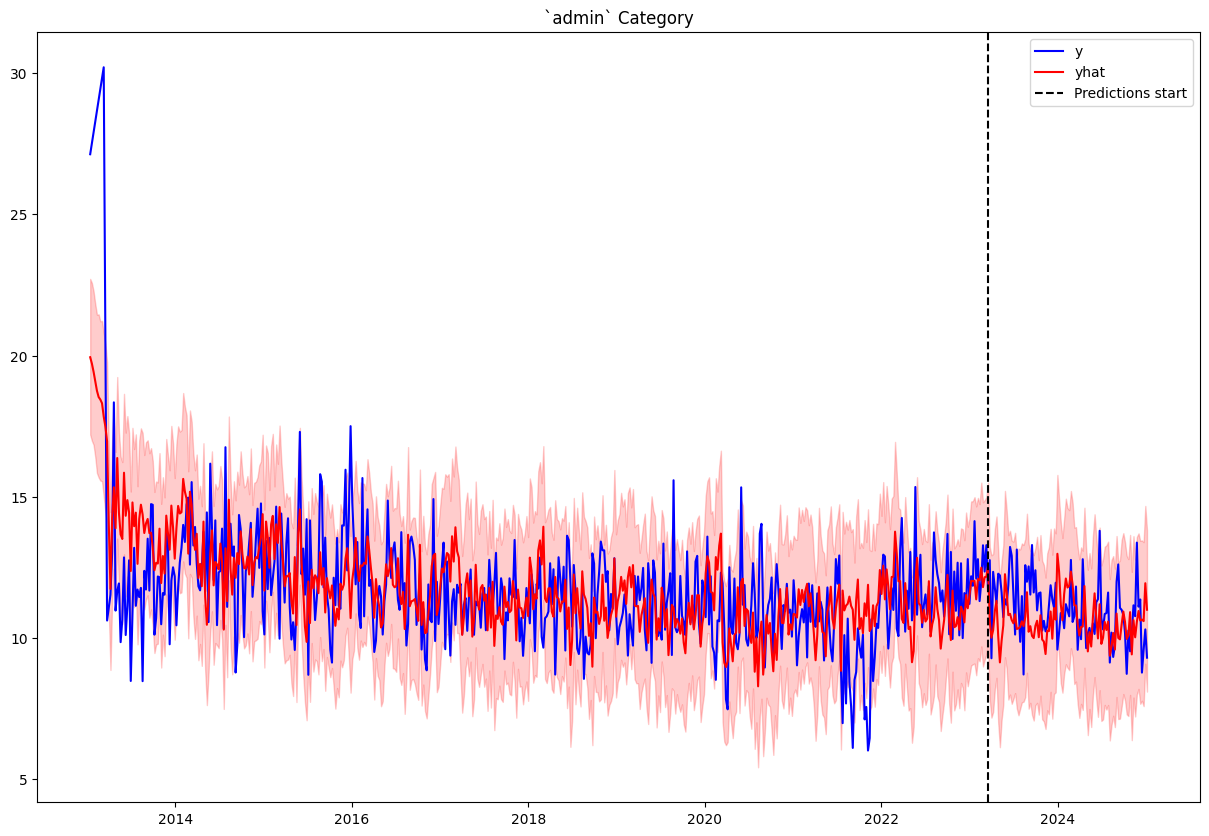

In [154]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_admin_W_all["ds"], ts_admin_W_all["y"], label="y", color="blue")

plt.plot(forecast_admin["ds"], forecast_admin["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['admin']['W']['train'].ds)[-1], color="black", linestyle="--",label="Predictions start")

plt.fill_between(forecast_admin["ds"], forecast_admin["yhat_lower"], forecast_admin["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.title("`admin` Category")

plt.show()

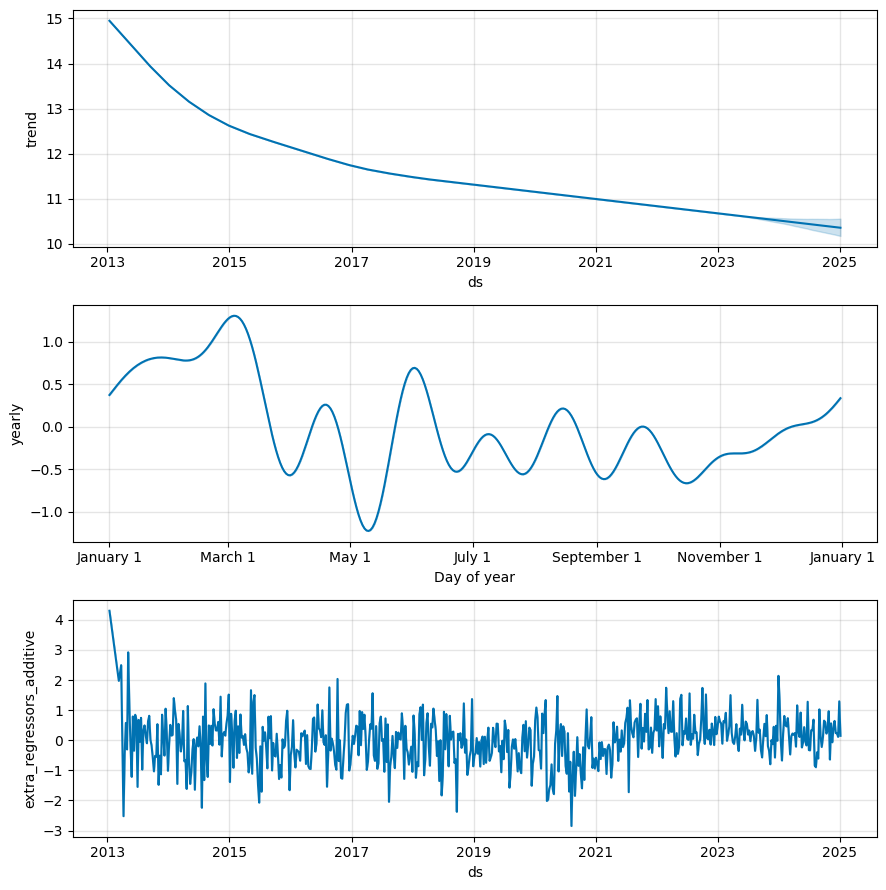

In [162]:
model_admin.plot_components(forecast_admin)
plt.show()

#### Compute error metrics

In [155]:
mae = mean_absolute_error(ts_admin_W_all["y"], forecast_admin["yhat"])
rmse = np.sqrt(mean_squared_error(ts_admin_W_all["y"], forecast_admin["yhat"]))
r2 = r2_score(ts_admin_W_all["y"], forecast_admin["yhat"])

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 1.48
RMSE: 2.10
R² Score: 0.36


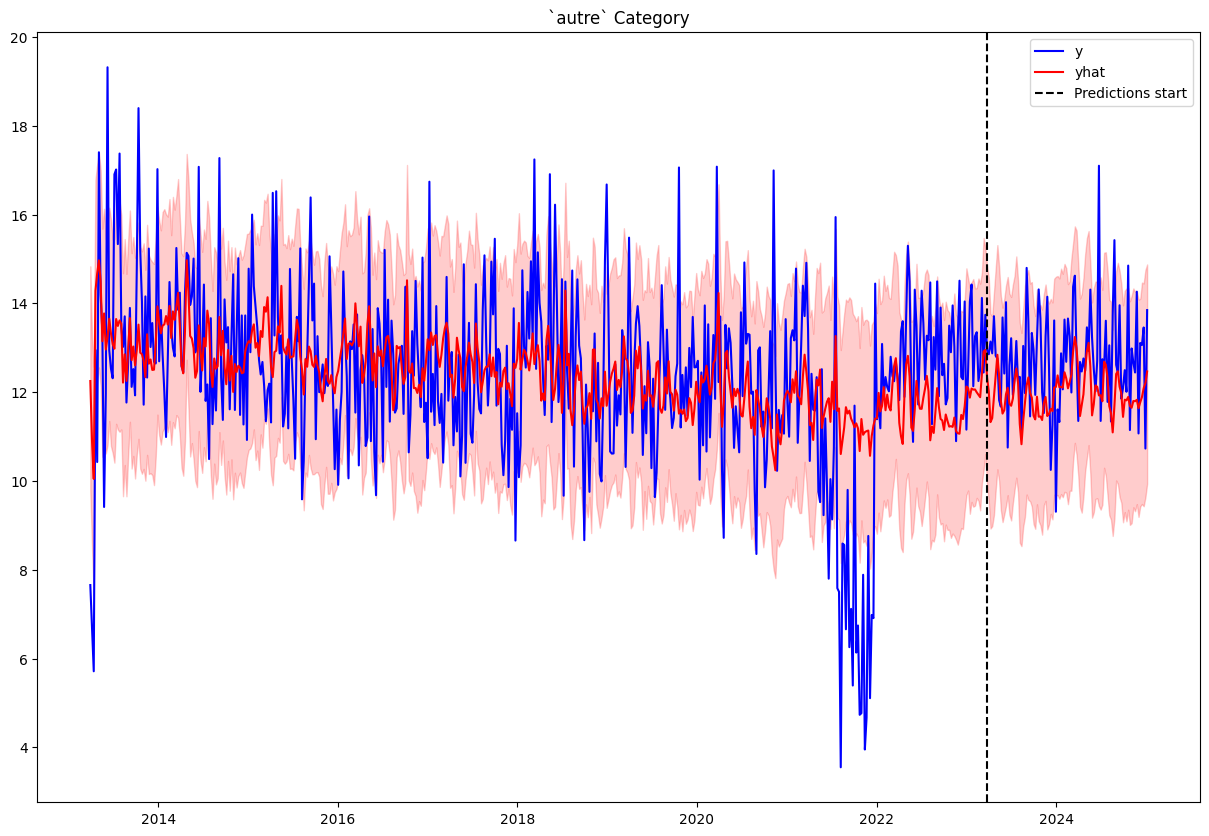

In [156]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_autre_W_all["ds"], ts_autre_W_all["y"], label="y", color="blue")

plt.plot(forecast_autre["ds"], forecast_autre["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['autre']['W']['train'].ds)[-1], color="black", linestyle="--",label="Predictions start")

plt.fill_between(forecast_autre["ds"], forecast_autre["yhat_lower"], forecast_autre["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.title("`autre` Category")

plt.show()

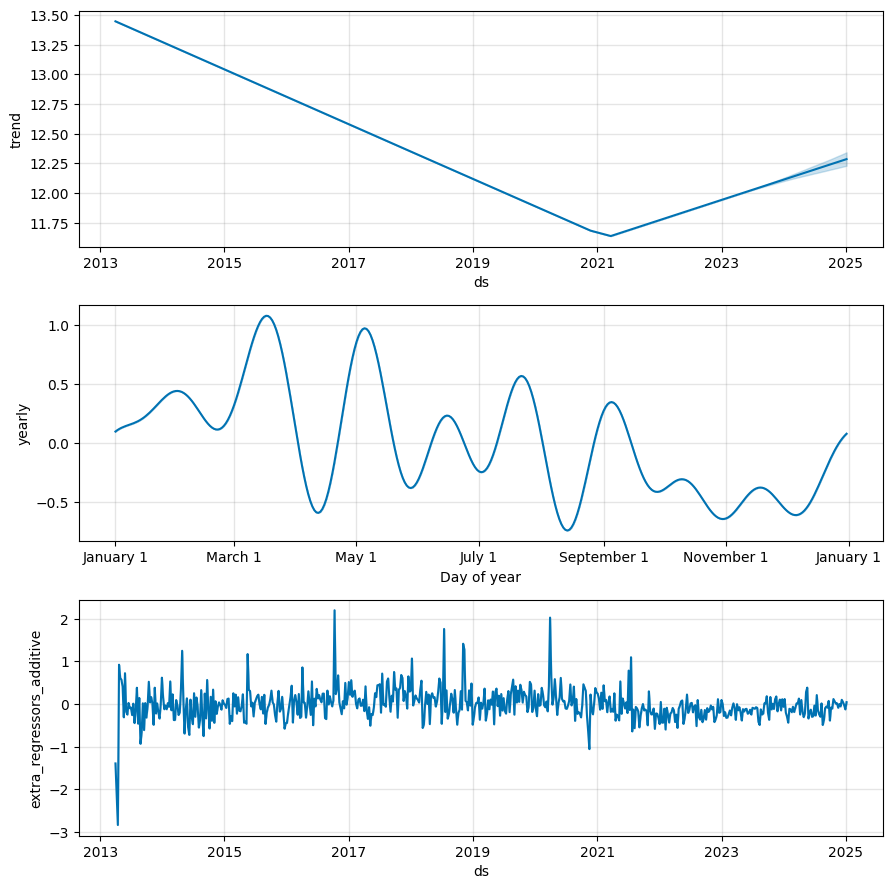

In [163]:
model_autre.plot_components(forecast_autre)
plt.show()

#### Compute error metrics

In [157]:
mae = mean_absolute_error(ts_autre_W_all["y"], forecast_autre["yhat"])
rmse = np.sqrt(mean_squared_error(ts_autre_W_all["y"], forecast_autre["yhat"]))
r2 = r2_score(ts_autre_W_all["y"], forecast_autre["yhat"])

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 1.39
RMSE: 1.86
R² Score: 0.13


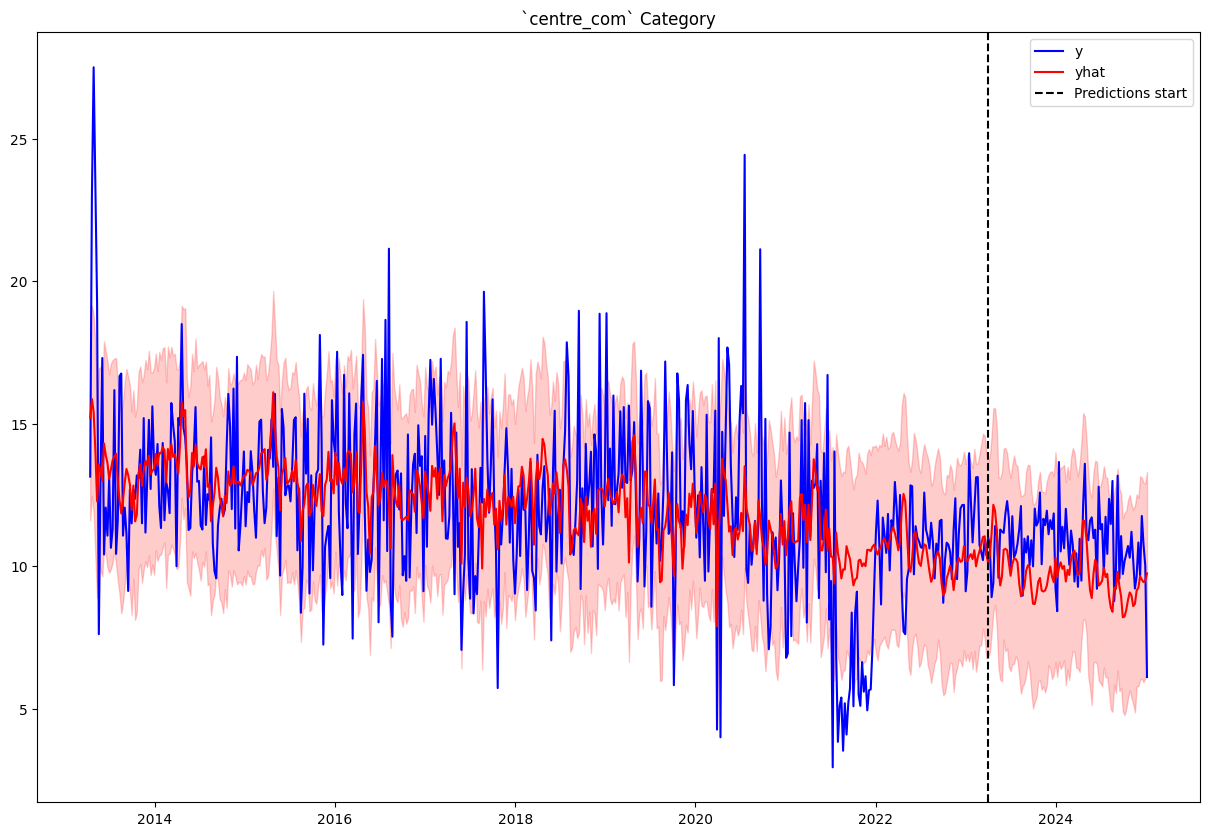

In [158]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_centre_com_W_all["ds"], ts_centre_com_W_all["y"], label="y", color="blue")

plt.plot(forecast_centre_com["ds"], forecast_centre_com["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['centre_com']['W']['train'].ds)[-1], color="black", linestyle="--",label="Predictions start")

plt.fill_between(forecast_centre_com["ds"], forecast_centre_com["yhat_lower"], forecast_centre_com["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.title("`centre_com` Category")

plt.show()

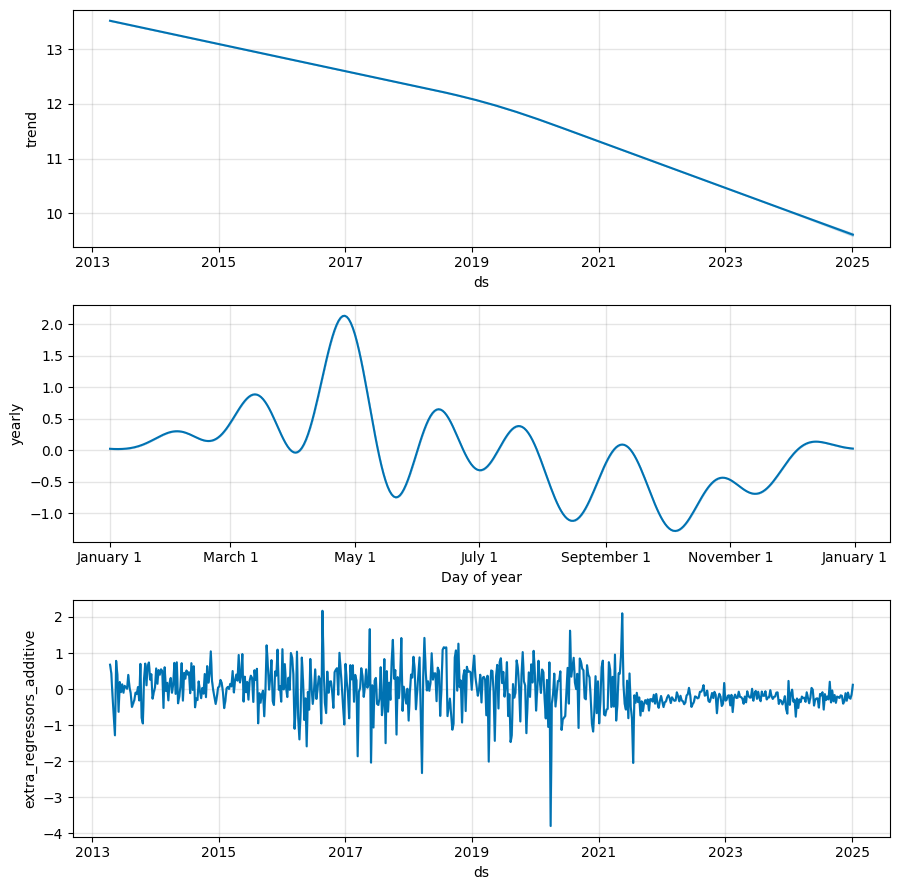

In [164]:
model_centre_com.plot_components(forecast_centre_com)
plt.show()

#### Compute error metrics

In [159]:
mae = mean_absolute_error(ts_centre_com_W_all["y"], forecast_centre_com["yhat"])
rmse = np.sqrt(mean_squared_error(ts_centre_com_W_all["y"], forecast_centre_com["yhat"]))
r2 = r2_score(ts_centre_com_W_all["y"], forecast_centre_com["yhat"])

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 1.97
RMSE: 2.62
R² Score: 0.18


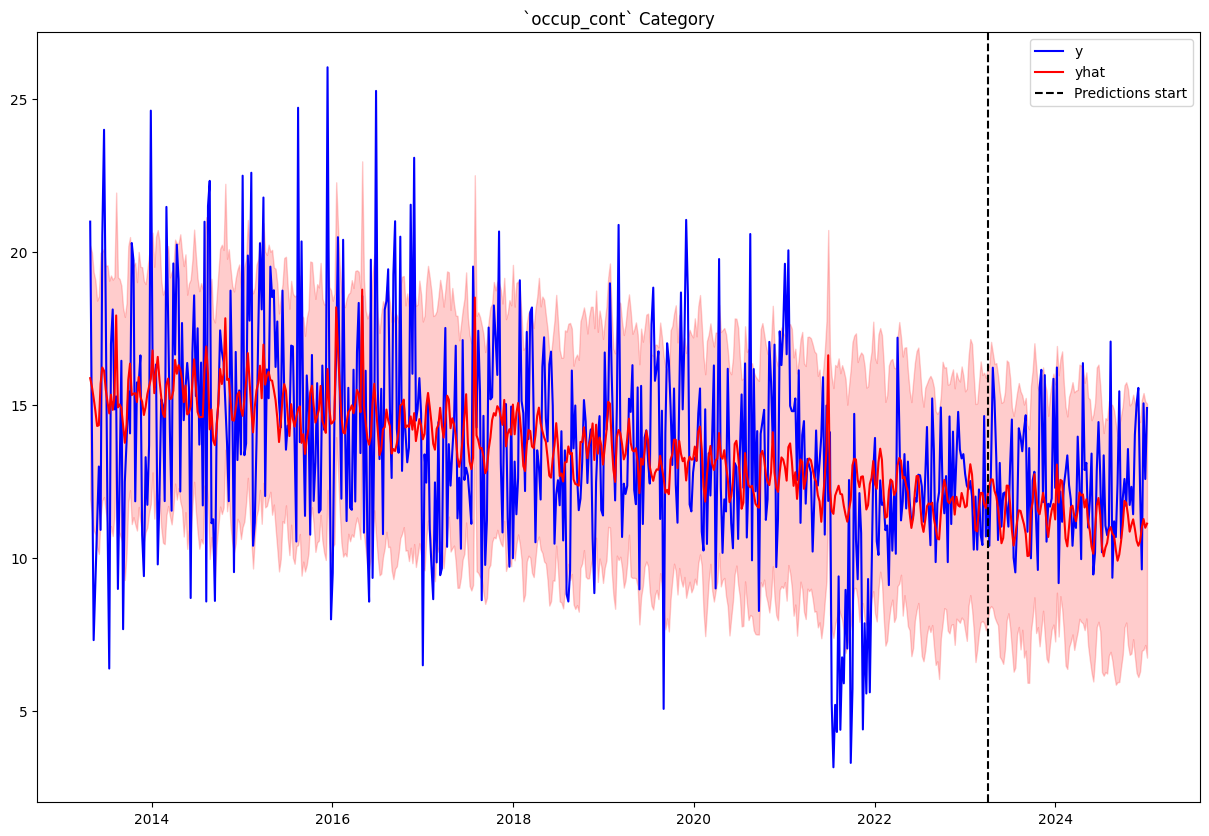

In [160]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_occup_cont_W_all["ds"], ts_occup_cont_W_all["y"], label="y", color="blue")

plt.plot(forecast_occup_cont["ds"], forecast_occup_cont["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['occup_cont']['W']['train'].ds)[-1], color="black", linestyle="--",label="Predictions start")

plt.fill_between(forecast_occup_cont["ds"], forecast_occup_cont["yhat_lower"], forecast_occup_cont["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.title("`occup_cont` Category")

plt.show()

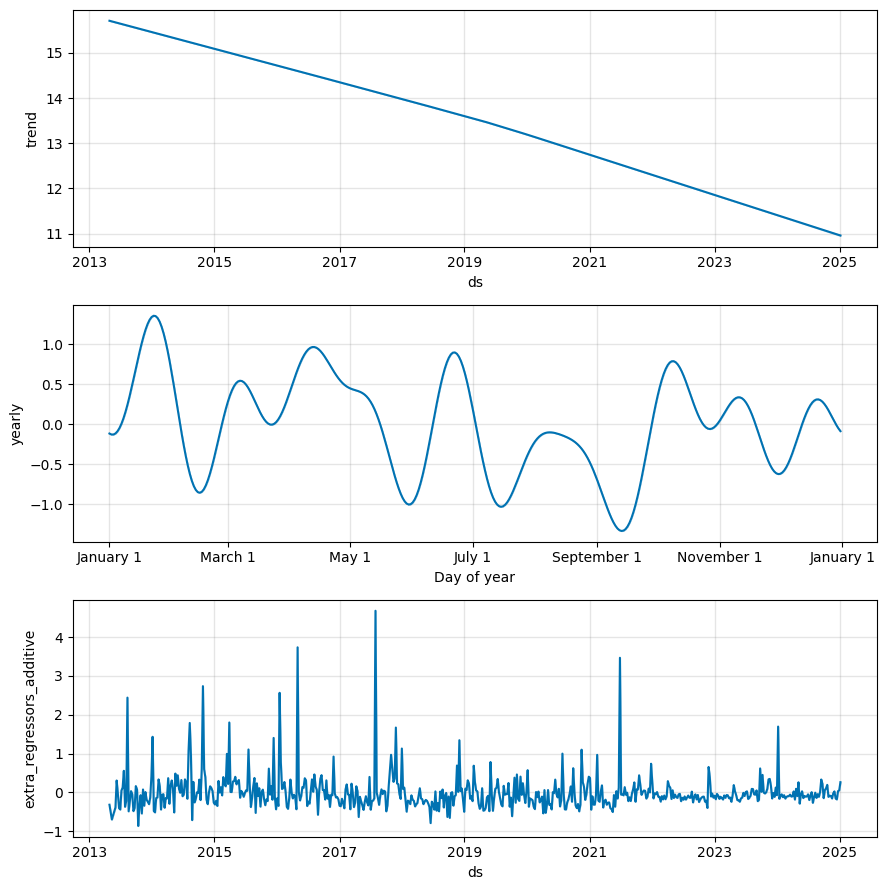

In [165]:
model_occup_cont.plot_components(forecast_occup_cont)
plt.show()

#### Compute error metrics

In [161]:
mae = mean_absolute_error(ts_occup_cont_W_all["y"], forecast_occup_cont["yhat"])
rmse = np.sqrt(mean_squared_error(ts_occup_cont_W_all["y"], forecast_occup_cont["yhat"]))
r2 = r2_score(ts_occup_cont_W_all["y"], forecast_occup_cont["yhat"])

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 2.36
RMSE: 3.10
R² Score: 0.15
